# Section 5: **Temporal Trends in Player Strength**

In [2]:
# Imports
import pandas as pd
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm # Use notebook version for better Jupyter integration
print("Libraries successfully imported")

Libraries successfully imported


In [3]:
# ----- Configuration -----

# Path to the processed Parquet dataset partitioned by Year
PROCESSED_DATA_DIR = Path(r"E:\EDA_chess_data\processed")

# Years to analyze
START_YEAR = 2018
END_YEAR = 2025 # Inclusive based on your file list

# Columns needed for this section's analysis (Added PlayerELO)
COLUMNS_TO_LOAD = ['Year', 'PlayerELO', 'PlayerRelativeEvalChange', 'IsBlunder_100cp', 'TimeSpentSec']

# Define ELO Bins and Labels
# Bins: Lower bounds (inclusive), upper bounds (exclusive). np.inf for the last bin.
ELO_BINS = [500, 1200, 1900, 2300, np.inf]
# Labels for the bins (must be one less than the number of bins)
ELO_LABELS = ['500-1199', '1200-1899', '1900-2299', '2300+']

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7) # Adjust figure size for multiple lines
plt.rcParams['figure.dpi'] = 90 # Adjust DPI for notebook display if needed

print("Configuration set:")
print(f"Data Directory: {PROCESSED_DATA_DIR}")
print(f"Years: {START_YEAR}-{END_YEAR}")
print(f"Columns to load: {COLUMNS_TO_LOAD}")
print(f"ELO Bins: {ELO_BINS}")
print(f"ELO Labels: {ELO_LABELS}")

Configuration set:
Data Directory: E:\EDA_chess_data\processed
Years: 2018-2025
Columns to load: ['Year', 'PlayerELO', 'PlayerRelativeEvalChange', 'IsBlunder_100cp', 'TimeSpentSec']
ELO Bins: [500, 1200, 1900, 2300, inf]
ELO Labels: ['500-1199', '1200-1899', '1900-2299', '2300+']


In [4]:
# ----- Data Loading -----

print(f"Loading data from {PROCESSED_DATA_DIR} for years {START_YEAR}-{END_YEAR}...")
all_moves_df = pd.DataFrame() # Initialize empty DataFrame

# Check if directory exists
if not PROCESSED_DATA_DIR.exists():
    print(f"ERROR: Processed data directory not found: {PROCESSED_DATA_DIR}")
else:
    try:
        dataset = ds.dataset(PROCESSED_DATA_DIR, format="parquet", partitioning="hive")
        print("Reading Parquet files into Pandas DataFrame (this might take a while)...")
        table = dataset.to_table(columns=COLUMNS_TO_LOAD)
        all_moves_df = table.to_pandas()
        print(f"Successfully loaded {len(all_moves_df):,} moves.")
        print("\nData Info:")
        all_moves_df.info(memory_usage='deep')

    except Exception as e:
        print(f"Error loading data: {type(e).__name__} - {e}")
        print("Proceeding with potentially empty DataFrame. Subsequent analyses may be skipped.")

Loading data from E:\EDA_chess_data\processed for years 2018-2025...
Reading Parquet files into Pandas DataFrame (this might take a while)...
Successfully loaded 10,593,734 moves.

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10593734 entries, 0 to 10593733
Data columns (total 5 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Year                      int32  
 1   PlayerELO                 int64  
 2   PlayerRelativeEvalChange  float64
 3   IsBlunder_100cp           object 
 4   TimeSpentSec              float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 534.1 MB


In [5]:
# ----- Data Preparation & CPL -----

if not all_moves_df.empty:
    print("Preparing data...")
    # Ensure 'Year' is integer type
    try:
        all_moves_df['Year'] = all_moves_df['Year'].astype(int)
    except Exception as e:
         print(f"Warning: Could not convert 'Year' column to integer. Error: {e}")

    # Calculate Centipawn Loss (CPL)
    print("Calculating CPL per move...")
    # Convert PlayerRelativeEvalChange to numeric, coercing errors
    eval_change_numeric = pd.to_numeric(all_moves_df['PlayerRelativeEvalChange'], errors='coerce')

    # Calculate CPL = max(0, -PlayerRelativeEvalChange)
    # Assign directly to the main DataFrame, NaN where eval_change was NaN
    all_moves_df['CPL'] = np.maximum(0, -eval_change_numeric)

    # Report how many moves have valid CPL
    valid_cpl_count = all_moves_df['CPL'].notna().sum()
    total_moves = len(all_moves_df)
    print(f"Calculated CPL for {valid_cpl_count:,} out of {total_moves:,} moves ({valid_cpl_count/total_moves:.1%}).")

    # Clean up - create a view or copy for analysis if preferred,
    # but here we'll just use the main df and filter later
    # cpl_valid_df = all_moves_df.dropna(subset=['CPL']).copy()

else:
    print("Skipping data preparation and CPL calculation as DataFrame is empty.")


Preparing data...
Calculating CPL per move...
Calculated CPL for 764,547 out of 10,593,734 moves (7.2%).


In [6]:
# ----- Data Preparation, ELO Binning & CPL -----

if not all_moves_df.empty:
    print("Preparing data...")
    # Ensure 'Year' is integer type
    try:
        all_moves_df['Year'] = all_moves_df['Year'].astype(int)
    except Exception as e:
         print(f"Warning: Could not convert 'Year' column to integer. Error: {e}")

    # --- ELO Binning ---
    print("Assigning ELO bins...")
    # Convert PlayerELO to numeric first, coercing errors (like '?') to NaN
    all_moves_df['PlayerELO_numeric'] = pd.to_numeric(all_moves_df['PlayerELO'], errors='coerce')

    # Apply binning using pd.cut
    # right=False means bins include the left edge but not the right (e.g., [1200, 1900))
    all_moves_df['ELOBin'] = pd.cut(all_moves_df['PlayerELO_numeric'],
                                    bins=ELO_BINS,
                                    labels=ELO_LABELS,
                                    right=False,
                                    include_lowest=True) # Include lowest value if needed, though 500 is likely lowest practical ELO

    # Report on binning results
    valid_elo_count = all_moves_df['PlayerELO_numeric'].notna().sum()
    binned_count = all_moves_df['ELOBin'].notna().sum()
    total_moves = len(all_moves_df)
    print(f"Found valid ELO for {valid_elo_count:,} moves ({valid_elo_count/total_moves:.1%}).")
    print(f"Assigned ELO bins to {binned_count:,} moves ({binned_count/total_moves:.1%}).")
    if valid_elo_count > binned_count:
        print(f"Note: {valid_elo_count - binned_count:,} moves had ELO outside defined bins (e.g., < {ELO_BINS[0]}).")

    # --- Calculate Centipawn Loss (CPL) ---
    print("\nCalculating CPL per move...")
    eval_change_numeric = pd.to_numeric(all_moves_df['PlayerRelativeEvalChange'], errors='coerce')
    all_moves_df['CPL'] = np.maximum(0, -eval_change_numeric)
    valid_cpl_count = all_moves_df['CPL'].notna().sum()
    print(f"Calculated CPL for {valid_cpl_count:,} out of {total_moves:,} moves ({valid_cpl_count/total_moves:.1%}).")

    # Display value counts for ELO Bins
    print("\nValue counts per ELO Bin:")
    print(all_moves_df['ELOBin'].value_counts(dropna=False)) # Show NaNs too

else:
    print("Skipping data preparation, ELO binning, and CPL calculation as DataFrame is empty.")

Preparing data...
Assigning ELO bins...
Found valid ELO for 10,593,734 moves (100.0%).
Assigned ELO bins to 10,593,374 moves (100.0%).
Note: 360 moves had ELO outside defined bins (e.g., < 500).

Calculating CPL per move...
Calculated CPL for 764,547 out of 10,593,734 moves (7.2%).

Value counts per ELO Bin:
ELOBin
1200-1899    6558264
1900-2299    2555828
500-1199     1071794
2300+         407488
NaN              360
Name: count, dtype: int64


Aggregating average CPL by year and ELO bin...

Average CPL per Year and ELO Bin (sample):
    Year     ELOBin         CPL
0   2018   500-1199  365.929106
1   2018  1200-1899  232.890283
2   2018  1900-2299  171.428631
3   2018      2300+  177.780513
4   2019   500-1199  372.150219
5   2019  1200-1899  236.037321
6   2019  1900-2299  189.780963
7   2019      2300+  202.011721
8   2020   500-1199  356.133813
9   2020  1200-1899  275.319468
10  2020  1900-2299  172.264553
11  2020      2300+   94.973157
12  2021   500-1199  375.395399
13  2021  1200-1899  237.474935
14  2021  1900-2299  173.882196
15  2021      2300+  103.207932
16  2022   500-1199  359.952493
17  2022  1200-1899  214.841945
18  2022  1900-2299  150.206507
19  2022      2300+  110.688287
20  2023   500-1199  316.698077
21  2023  1200-1899  225.131639
22  2023  1900-2299  154.962599
23  2023      2300+  119.527505
24  2024   500-1199  290.227908
25  2024  1200-1899  201.497225
26  2024  1900-2299  154.409355
27  2024     

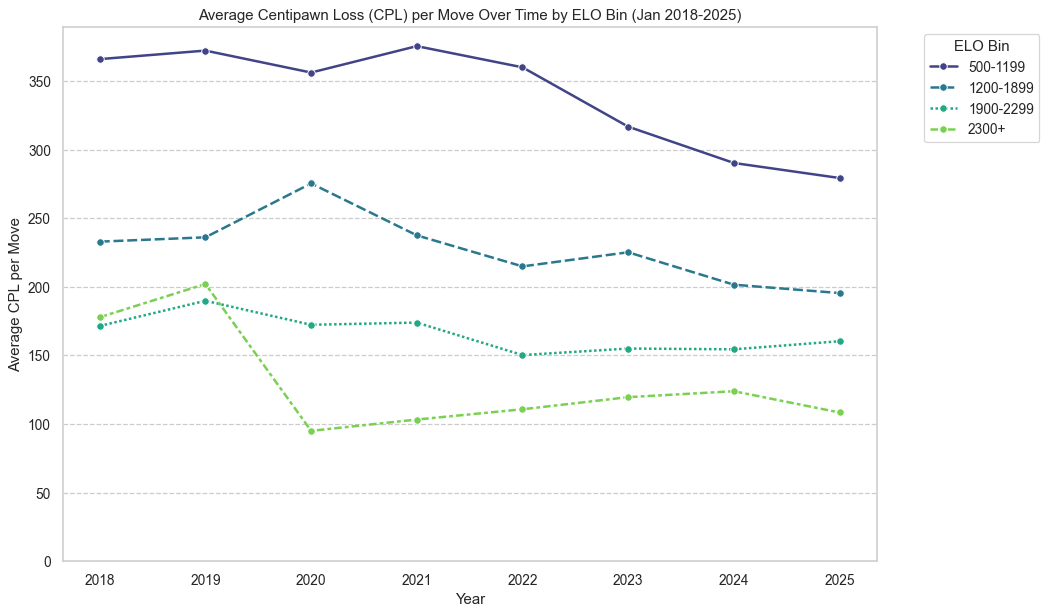

In [7]:
# ----- CPL Analysis and Plot by ELO Bin -----

if not all_moves_df.empty and 'CPL' in all_moves_df.columns and 'ELOBin' in all_moves_df.columns:
    print("Aggregating average CPL by year and ELO bin...")

    # Filter out moves where CPL or ELO Bin couldn't be determined
    cpl_analysis_df = all_moves_df.dropna(subset=['CPL', 'ELOBin'])

    if not cpl_analysis_df.empty:
        # Group by year and ELO bin, then calculate mean CPL
        avg_cpl_per_year_elo = cpl_analysis_df.groupby(['Year', 'ELOBin'], observed=True)['CPL'].mean().reset_index()
        # 'observed=True' is good practice with categorical groupby to avoid combinations with 0 count

        print("\nAverage CPL per Year and ELO Bin (sample):")
        print(avg_cpl_per_year_elo.head(50))

        # --- Plotting ---
        print("\nPlotting Average CPL Over Time by ELO Bin...")
        plt.figure(figsize=(14, 7))
        ax = sns.lineplot(
            data=avg_cpl_per_year_elo,
            x='Year',
            y='CPL',
            hue='ELOBin',
            style='ELOBin', # Different line styles can help distinguish
            palette='viridis',
            marker='o',
            linewidth=2
        )

        plt.title('Average Centipawn Loss (CPL) per Move Over Time by ELO Bin (Jan 2018-2025)')
        plt.xlabel('Year')
        plt.ylabel('Average CPL per Move')
        plt.xticks(ticks=avg_cpl_per_year_elo['Year'].unique(), labels=avg_cpl_per_year_elo['Year'].unique())
        ax.yaxis.grid(True, linestyle='--')
        ax.xaxis.grid(False)
        plt.ylim(bottom=0)
        plt.legend(title='ELO Bin', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()
    else:
        print("No valid CPL data found for any ELO bin to aggregate and plot.")

else:
    print("Skipping CPL analysis by ELO Bin: DataFrame is empty or required columns ('CPL', 'ELOBin') are missing.")


Calculating Blunder Rate (>100cp loss) by year and ELO bin...


C:\Users\Admin\AppData\Local\Temp\ipykernel_15400\432005329.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blunder_valid_df['IsBlunder'] = blunder_valid_df['IsBlunder'].astype(bool)



Blunder Rate per Year and ELO Bin (sample):
    Year     ELOBin  BlunderRatePercent
0   2018   500-1199           30.248541
1   2018  1200-1899           20.405081
2   2018  1900-2299           16.720517
3   2018      2300+           14.201183
4   2019   500-1199           31.954536
5   2019  1200-1899           22.105388
6   2019  1900-2299           17.605634
7   2019      2300+           15.201192
8   2020   500-1199           30.557717
9   2020  1200-1899           23.091316
10  2020  1900-2299           18.165994
11  2020      2300+           13.711002
12  2021   500-1199           32.349107
13  2021  1200-1899           24.630774
14  2021  1900-2299           18.615529
15  2021      2300+           15.071770
16  2022   500-1199           33.298763
17  2022  1200-1899           25.768287
18  2022  1900-2299           19.685343
19  2022      2300+           16.864383
20  2023   500-1199           27.990431
21  2023  1200-1899           20.928306
22  2023  1900-2299           15.71

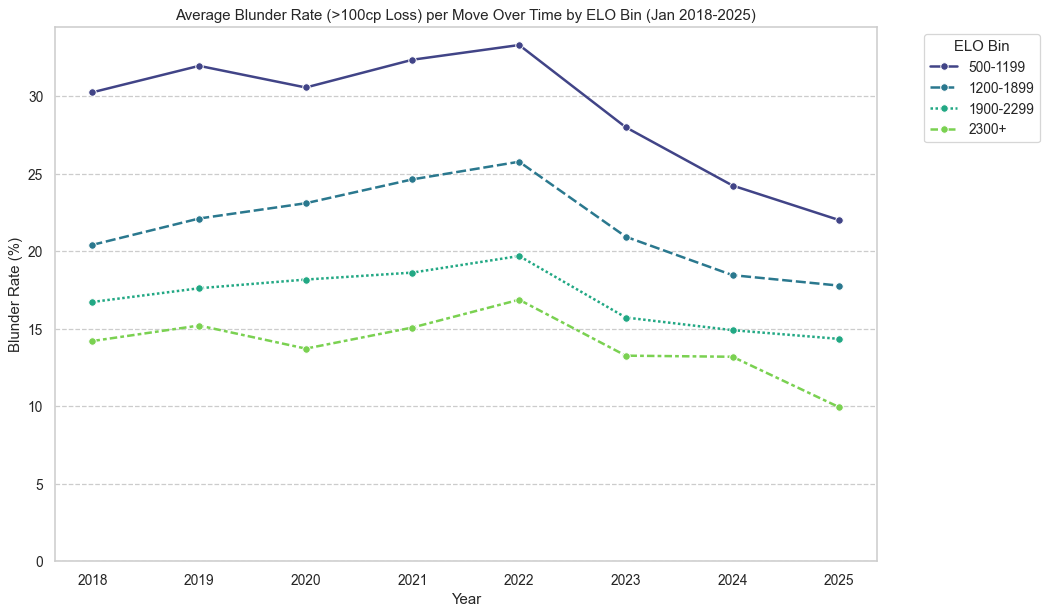

In [8]:
# ----- Blunder Rate Analysis and Plot by ELO Bin -----

if not all_moves_df.empty and 'IsBlunder_100cp' in all_moves_df.columns and 'ELOBin' in all_moves_df.columns:
    print("\nCalculating Blunder Rate (>100cp loss) by year and ELO bin...")

    # Make a temporary copy for manipulation
    temp_df = all_moves_df[['Year', 'ELOBin', 'IsBlunder_100cp']].copy()

    # Convert blunder flag to numeric/boolean, coercing errors
    temp_df['IsBlunder'] = pd.to_numeric(temp_df['IsBlunder_100cp'], errors='coerce')

    # Filter out moves where Blunder status or ELO Bin is unknown
    blunder_valid_df = temp_df.dropna(subset=['IsBlunder', 'ELOBin'])
    blunder_valid_df['IsBlunder'] = blunder_valid_df['IsBlunder'].astype(bool)

    if not blunder_valid_df.empty:
        # Group by year and ELO bin, calculate mean blunder rate
        blunder_rate_per_year_elo = blunder_valid_df.groupby(['Year', 'ELOBin'], observed=True)['IsBlunder'].mean().reset_index()
        blunder_rate_per_year_elo['BlunderRatePercent'] = blunder_rate_per_year_elo['IsBlunder'] * 100

        print("\nBlunder Rate per Year and ELO Bin (sample):")
        print(blunder_rate_per_year_elo[['Year', 'ELOBin', 'BlunderRatePercent']].head(50))

        # --- Plotting ---
        print("\nPlotting Blunder Rate Over Time by ELO Bin...")
        plt.figure(figsize=(14, 7))
        ax = sns.lineplot(
            data=blunder_rate_per_year_elo,
            x='Year',
            y='BlunderRatePercent',
            hue='ELOBin',
            style='ELOBin',
            marker='o',
            palette='viridis', # Use a different color palette
            linewidth=2
        )

        plt.title('Average Blunder Rate (>100cp Loss) per Move Over Time by ELO Bin (Jan 2018-2025)')
        plt.xlabel('Year')
        plt.ylabel('Blunder Rate (%)')
        plt.xticks(ticks=blunder_rate_per_year_elo['Year'].unique(), labels=blunder_rate_per_year_elo['Year'].unique())
        ax.yaxis.grid(True, linestyle='--')
        ax.xaxis.grid(False)
        plt.ylim(bottom=0)
        plt.legend(title='ELO Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()
    else:
        print("No valid blunder information found for any ELO bin to calculate rate.")

else:
    print("Skipping Blunder Rate analysis by ELO Bin: DataFrame is empty or required columns ('IsBlunder_100cp', 'ELOBin') are missing.")


Calculating Average Time Spent per Move by year and ELO bin...

Average Time Spent per Year and ELO Bin (sample):
    Year     ELOBin  TimeSpent
0   2018   500-1199   5.527281
1   2018  1200-1899   4.322875
2   2018  1900-2299   2.863082
3   2018      2300+   1.582665
4   2019   500-1199   4.991841
5   2019  1200-1899   4.060937
6   2019  1900-2299   2.892365
7   2019      2300+   1.919370
8   2020   500-1199   4.836211
9   2020  1200-1899   4.001913
10  2020  1900-2299   3.038940
11  2020      2300+   1.726513
12  2021   500-1199   5.018651
13  2021  1200-1899   4.159491
14  2021  1900-2299   3.269811
15  2021      2300+   2.374952
16  2022   500-1199   4.554457
17  2022  1200-1899   3.921676
18  2022  1900-2299   3.362788
19  2022      2300+   2.552051
20  2023   500-1199   4.592121
21  2023  1200-1899   3.921127
22  2023  1900-2299   3.176263
23  2023      2300+   2.066294
24  2024   500-1199   4.686226
25  2024  1200-1899   3.911208
26  2024  1900-2299   3.036420
27  2024      230

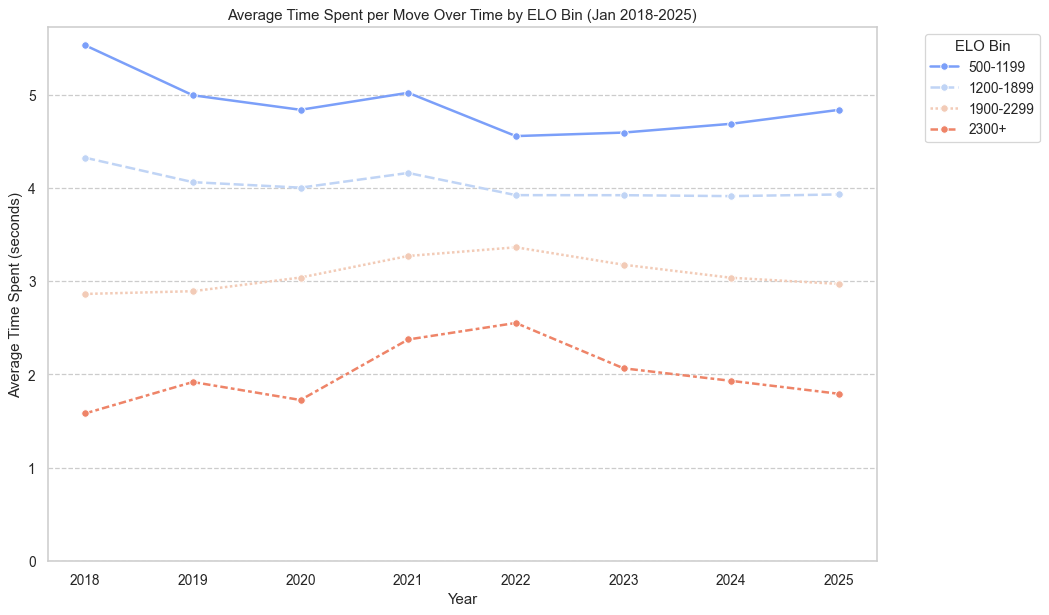

In [9]:
# ----- Average Time Spent Analysis and Plot by ELO Bin -----

if not all_moves_df.empty and 'TimeSpentSec' in all_moves_df.columns and 'ELOBin' in all_moves_df.columns:
    print("\nCalculating Average Time Spent per Move by year and ELO bin...")

    # Make a temporary copy
    temp_df = all_moves_df[['Year', 'ELOBin', 'TimeSpentSec']].copy()

    # Convert time spent to numeric, coerce errors
    temp_df['TimeSpent'] = pd.to_numeric(temp_df['TimeSpentSec'], errors='coerce')

    # Filter out invalid time spent (NaN, negative) and missing ELO Bin
    time_valid_df = temp_df.dropna(subset=['TimeSpent', 'ELOBin'])
    time_valid_df = time_valid_df[time_valid_df['TimeSpent'] >= 0] # Filter out negatives

    if not time_valid_df.empty:
        # Group by year and ELO bin, calculate mean time spent
        avg_time_per_year_elo = time_valid_df.groupby(['Year', 'ELOBin'], observed=True)['TimeSpent'].mean().reset_index()

        print("\nAverage Time Spent per Year and ELO Bin (sample):")
        print(avg_time_per_year_elo.head(50))

        # --- Plotting ---
        print("\nPlotting Average Time Spent Over Time by ELO Bin...")
        plt.figure(figsize=(14, 7))
        ax = sns.lineplot(
            data=avg_time_per_year_elo,
            x='Year',
            y='TimeSpent',
            hue='ELOBin',
            style='ELOBin',
            marker='o',
            palette='coolwarm', # Yet another palette
            linewidth=2
        )

        plt.title('Average Time Spent per Move Over Time by ELO Bin (Jan 2018-2025)')
        plt.xlabel('Year')
        plt.ylabel('Average Time Spent (seconds)')
        plt.xticks(ticks=avg_time_per_year_elo['Year'].unique(), labels=avg_time_per_year_elo['Year'].unique())
        ax.yaxis.grid(True, linestyle='--')
        ax.xaxis.grid(False)
        plt.ylim(bottom=0)
        plt.legend(title='ELO Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()
    else:
        print("No valid time spent information found for any ELO bin to calculate average.")

else:
    print("Skipping Average Time Spent analysis by ELO Bin: DataFrame is empty or required columns ('TimeSpentSec', 'ELOBin') are missing.")